In [269]:
import os
import functools
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import io

In [270]:
content_image_path = './content.jpg' 
style_image_path = './style.jpg' 

content_blending_ratio = 0.05

output_image_size = 512

content_img_size = 384
style_img_size = 256

In [271]:
def crop_center(image):
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

In [272]:
# Function to load an image from a file, and add a batch dimension.
def load_style_image(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to load an image from a file, and add a batch dimension.
def load_content_img(path_to_img):
  image_pixels = np.array(Image.open(path_to_img))
  if image_pixels.shape[-1] == 4:
    image_pixels = Image.fromarray(image_pixels)
    img = image_pixels.convert('RGB')
    img = np.array(img)
    img = tf.convert_to_tensor(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img
  elif image_pixels.shape[-1] == 3:
    img = tf.convert_to_tensor(image_pixels)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img
  elif image_pixels.shape[-1] == 1:
    raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
  print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [273]:
def show_images(images, titles=None):
  """Plot a list of images."""
  cols = len(images)
  titles = titles if titles is not None else [""] * len(images)
  rows = len(images) // cols + 1
  plt.figure(figsize=(20, 20 * rows // cols))
  for i, (image, title) in enumerate(list(zip(images, titles))):
    plt.subplot(rows, cols, i + 1)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.imshow(image[0], interpolation='nearest')
  plt.show()

In [274]:
# load image to transform
content_image = load_content_img(content_image_path)
content_image = preprocess_image(content_image, content_img_size)
# load style image to transfert
style_image = load_style_image(style_image_path)
style_image = preprocess_image(style_image, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

In [275]:
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', './model/lite-model_arbitrary-image-stylization-inceptionv3_dr_transfer_1.tflite')
style_transform_path = style_transform_path = tf.keras.utils.get_file('style_transform.tflite', './model/lite-model_arbitrary-image-stylization-inceptionv3_dr_transfer_1.tflite')

In [276]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, content_image)


Calculating style bottleneck...
Style Bottleneck Shape: (1, 1, 1, 100)
Stylizing image. It should not take more than three minutes...


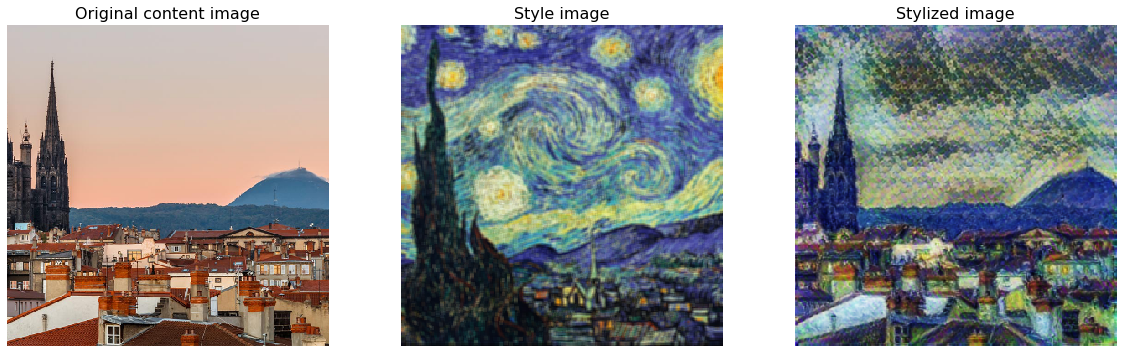

In [277]:
# show images
show_images([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [278]:
# save stylized image file
tf.keras.preprocessing.image.save_img('./output.jpg', stylized_image[0])